# Import Libraries

In [421]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split


# Load the Data

In [422]:
# Load the data
df = pd.read_csv("cleaned_coursera_dataset.csv")

In [423]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)


In [424]:
df

,Course Title,Rating,Provider,Level,Reviews,Type,Duration / Weeks
0,Google Data Analytics,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,Google Cybersecurity,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,Google Project Management:,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,Google Digital Marketing & E-commerce,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,Google UX Design,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...,...
4299,Fundamentals of Machine Learning for Supply Chain,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,Generative Design for Industrial Applications,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,Social Media and Social Content Strategy,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,Iteration Planning and PI in Scaled Agile Fram...,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [425]:
df.drop('Course Title', axis=1, inplace=True)

# Aggregat
Aggregating categorical feature

In [426]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Provider', 'Level', 'Type', 'Duration / Weeks'], dtype='object')

#  One hot encoding

In [427]:
# One hot encoding
categorical_features = df.select_dtypes(include=['object']).columns
df_dummies = df.copy()

In [428]:
encoder = LabelEncoder()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding on each categorical feature
for col in categorical_features:
    df_dummies[col] = label_encoder.fit_transform(df_dummies[col])

In [429]:
categorical_features

Index(['Provider', 'Level', 'Type', 'Duration / Weeks'], dtype='object')

In [430]:
df_dummies.shape

(4304, 6)

# Split the players to 5 categories by quantile

In [431]:
# Split the players to 5 categories by percentiles
p20 = df_dummies['Rating'].quantile(0.20)
p40 = df_dummies['Rating'].quantile(0.40)
p60 = df_dummies['Rating'].quantile(0.60)
p80 = df_dummies['Rating'].quantile(0.80)

def categorize_Rating(Rating):
    if Rating < p20:
        return 'Very low rating'
    elif Rating < p40:
        return 'Low rating'
    if Rating < p60:
        return 'Average rating'
    elif Rating < p80:
        return 'Above average rating'
    else:
        return 'Excellent rating'

df_dummies['categorize_Rating'] = df_dummies['Rating'].apply(categorize_Rating)
df_dummies.drop('Rating', axis=1, inplace=True)

# encoder

# Feature selection
- Step 1 : Calculate Correlation Matrix
- Step 2 : Set Correlation Threshold
- Step 3 : Select Features Based on Correlation

In [432]:
# Feature selection based on correlation
'''correlation = df.corr(numeric_only=True)
threshold = 0.07 
selected_features = correlation[abs(correlation['categorize_Rating']) > threshold].index
'''
correlation = df_dummies.corr(numeric_only=True)
print(correlation['Duration / Weeks'].sort_values(ascending=False))


Duration / Weeks    1.000000
Type                0.076099
Level               0.048505
Provider            0.047308
Reviews             0.005513
Name: Duration / Weeks, dtype: float64


In [433]:
threshold = 0.04
selected_features = correlation[abs(correlation['Duration / Weeks']) > \
threshold]['Duration / Weeks'].index
selected_features

Index(['Provider', 'Level', 'Type', 'Duration / Weeks'], dtype='object')

In [434]:
df_dummies[selected_features].dtypes

Provider            int32
Level               int32
Type                int32
Duration / Weeks    int32
dtype: object

# Data Scaling
- Selecting relevant features.
- Separating the target variable.
- Standardizing the feature values to have a mean of 0 and a standard deviation of 1.

In [435]:
# # Data Scaling
X = df_dummies[selected_features]

# scaler = StandardScaler()
# X['Provider'] = scaler.fit_transform(X['Provider'])


In [436]:
wcss = []
for i in range(2, 20):  
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

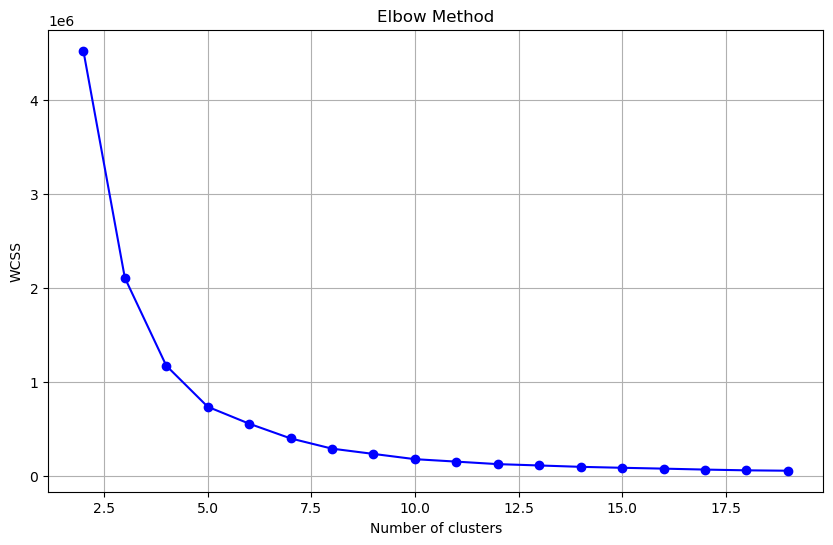

In [437]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Grid Search Cross-Validation
This code performs a comprehensive search to find the best hyperparameters for K-Means clustering using Grid Search Cross-Validation

In [438]:
'''param_grid_kmeans = {
    'n_clusters': [2,3,4,5,6,7,8],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 400, 500]
}

kmeans = KMeans()
grid_search_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid_kmeans, cv=5, scoring='accuracy')
grid_search_kmeans.fit(X_scaled)

best_params_kmeans = grid_search_kmeans.best_params_
best_kmeans = KMeans(n_clusters=best_params_kmeans['n_clusters'],
                     init=best_params_kmeans['init'],
                     max_iter=best_params_kmeans['max_iter'])
best_kmeans.fit(X_scaled)'''

"param_grid_kmeans = {\n    'n_clusters': [2,3,4,5,6,7,8],\n    'init': ['k-means++', 'random'],\n    'max_iter': [300, 400, 500]\n}\n\nkmeans = KMeans()\ngrid_search_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid_kmeans, cv=5, scoring='accuracy')\ngrid_search_kmeans.fit(X_scaled)\n\nbest_params_kmeans = grid_search_kmeans.best_params_\nbest_kmeans = KMeans(n_clusters=best_params_kmeans['n_clusters'],\n                     init=best_params_kmeans['init'],\n                     max_iter=best_params_kmeans['max_iter'])\nbest_kmeans.fit(X_scaled)"

In [439]:
'''from sklearn.metrics import silhouette_score, make_scorer
param_grid_kmeans = {
    'n_clusters': [8],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 400, 500]
}

# Create a custom scorer using silhouette_score
def silhouette_scorer(estimator, X):
    labels = estimator.labels_
    if len(set(labels)) == 1:  # if only one cluster is found
        return -1
    return silhouette_score(X, labels)

silhouette_scorer = make_scorer(silhouette_scorer, greater_is_better=True)

# Set up GridSearchCV with the custom scorer
kmeans = KMeans()
grid_search_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid_kmeans, cv=5, scoring=silhouette_scorer)

# Fit GridSearchCV
grid_search_kmeans.fit(X_scaled)

# Retrieve best parameters and fit the best model
best_params_kmeans = grid_search_kmeans.best_params_
best_kmeans = KMeans(n_clusters=best_params_kmeans['n_clusters'],
                     init=best_params_kmeans['init'],
                     max_iter=best_params_kmeans['max_iter'])
best_kmeans.fit(X_scaled)

# Print best parameters and silhouette score
print(f'Best parameters: {best_params_kmeans}')
labels = best_kmeans.labels_
best_silhouette_score = silhouette_score(X_scaled, labels)
print(f'Best Silhouette Score: {best_silhouette_score}')'''

"from sklearn.metrics import silhouette_score, make_scorer\nparam_grid_kmeans = {\n    'n_clusters': [8],\n    'init': ['k-means++', 'random'],\n    'max_iter': [300, 400, 500]\n}\n\n# Create a custom scorer using silhouette_score\ndef silhouette_scorer(estimator, X):\n    labels = estimator.labels_\n    if len(set(labels)) == 1:  # if only one cluster is found\n        return -1\n    return silhouette_score(X, labels)\n\nsilhouette_scorer = make_scorer(silhouette_scorer, greater_is_better=True)\n\n# Set up GridSearchCV with the custom scorer\nkmeans = KMeans()\ngrid_search_kmeans = GridSearchCV(estimator=kmeans, param_grid=param_grid_kmeans, cv=5, scoring=silhouette_scorer)\n\n# Fit GridSearchCV\ngrid_search_kmeans.fit(X_scaled)\n\n# Retrieve best parameters and fit the best model\nbest_params_kmeans = grid_search_kmeans.best_params_\nbest_kmeans = KMeans(n_clusters=best_params_kmeans['n_clusters'],\n                     init=best_params_kmeans['init'],\n                     max_iter=

In [440]:
# Building the KMeans Model
from sklearn.metrics import silhouette_score, make_scorer
optimal_clusters = 5

# Initialize and train the KMeans model
best_kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
x_kmeans = best_kmeans.fit_predict(X)

# Get the cluster labels
labels = best_kmeans.labels_

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, x_kmeans)

print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6438011844590494


In [441]:
df_dummies.columns

Index(['Provider', 'Level', 'Reviews', 'Type', 'Duration / Weeks',
       'categorize_Rating'],
      dtype='object')

In [442]:
df_dummies.columns

Index(['Provider', 'Level', 'Reviews', 'Type', 'Duration / Weeks',
       'categorize_Rating'],
      dtype='object')

# evaluate model

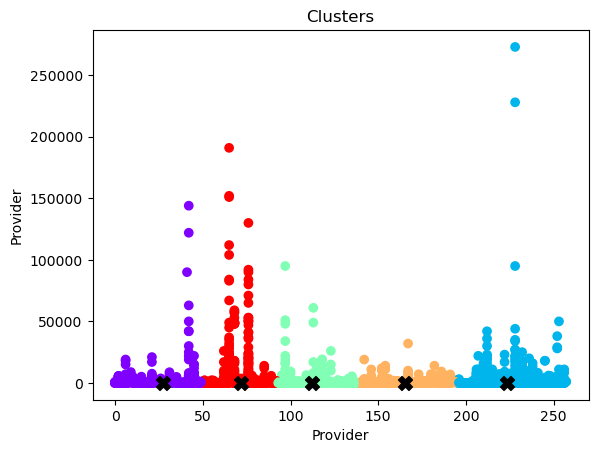

In [443]:
# plotting the clusters
plt.scatter(df_dummies['Provider'], df_dummies['Reviews'], c=x_kmeans, cmap='rainbow')
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], s=100, c='black', marker='X')
plt.title('Clusters')
plt.xlabel('Provider')
plt.ylabel('Provider')
plt.show() 

In [444]:
X['Duration / Weeks'].unique()

array([1, 2, 0])

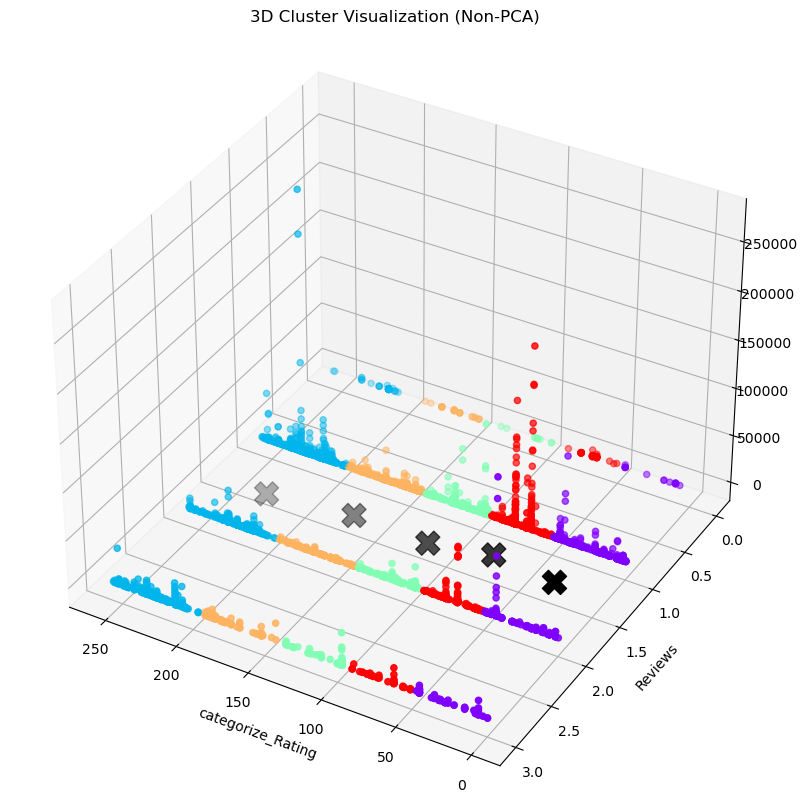

In [470]:
# Assuming 'X' has three features
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the three features and cluster assignments
ax.scatter(df_dummies['Provider'], df_dummies['Level'], df_dummies['Reviews'], c=x_kmeans, cmap='rainbow', marker='o')

# Plot the cluster centers
ax.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], best_kmeans.cluster_centers_[:, 2], s=300, c='black', marker='X')

# Labels and title
ax.view_init(elev=35, azim=120)
ax.set_xlabel('categorize_Rating')
ax.set_ylabel('Reviews')
ax.set_zlabel('Duration / Weeks_12 - 24', labelpad=20)
ax.set_title('3D Cluster Visualization (Non-PCA)')
plt.show()

In [446]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# Split the data to train and test

In [447]:
# for train_idx, test_idx in cv.split(X_scaled, y):
#     X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     # Fit the model
#     y_pred_train = best_kmeans.fit_predict(X_train)
    
#     # Assign cluster labels to the test set
#     y_pred_test = best_kmeans.predict(X_test)
    
#     # Evaluate the clustering using adjusted rand index
#     score = metrics.adjusted_rand_score(y_test, y_pred_test)
#     scores.append(score)

# Output the cross-validation scores for KMeans

In [448]:
print(f'Best KMeans Parameters: {best_kmeans}')
print(f'Cross-Validation Scores for KMeans: {scores}')
print(f'Mean Cross-Validation Score for KMeans: {np.mean(scores)}')

Best KMeans Parameters: KMeans(n_clusters=5, n_init=10, random_state=42)
Cross-Validation Scores for KMeans: []
Mean Cross-Validation Score for KMeans: nan


# Train the model

In [449]:
# Final Model Training

'''y_pred = best_kmeans.fit_predict(X_scaled)
labelss = y_pred.labels_

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_scaled, labelss)

print(f'Silhouette Score: {silhouette_avg}')'''

"y_pred = best_kmeans.fit_predict(X_scaled)\nlabelss = y_pred.labels_\n\n# Calculate the silhouette score\nsilhouette_avg = silhouette_score(X_scaled, labelss)\n\nprint(f'Silhouette Score: {silhouette_avg}')"

# Clusters distribution

In [450]:
clusters = kmeans.labels_


In [451]:
print(clusters)

[ 1  1  1 ...  7 15 15]


In [452]:
clusters2 = kmeans.predict(X)
print(clusters2)

[ 1  1  1 ...  7 15 15]


In [453]:
df_dummies['Cluster'] = kmeans.labels_

In [454]:
from sklearn.preprocessing import LabelEncoder

df_final = df.copy()
#df_final_copy = df_final
le = LabelEncoder()


for column in df_final.select_dtypes(include=['object']).columns:
    df_final[column] = le.fit_transform(df_final[column])

df_final['Cluster'] = df_dummies['Cluster']

In [455]:
df_final

,Rating,Provider,Level,Reviews,Type,Duration / Weeks,Cluster
0,4.8,65,1,151000.0,1,1,1
1,4.8,65,1,35000.0,1,1,1
2,4.8,65,1,112000.0,1,1,1
3,4.8,65,1,30000.0,1,1,1
4,4.8,65,1,83000.0,1,1,1
...,...,...,...,...,...,...,...
4299,3.9,109,1,32.0,0,0,5
4300,4.8,10,2,88.0,0,0,3
4301,4.4,44,1,62.0,0,0,7
4302,3.5,18,2,6.0,0,0,15


In [456]:
grouped_df = df_final.groupby('Cluster')

In [457]:
grouped_df

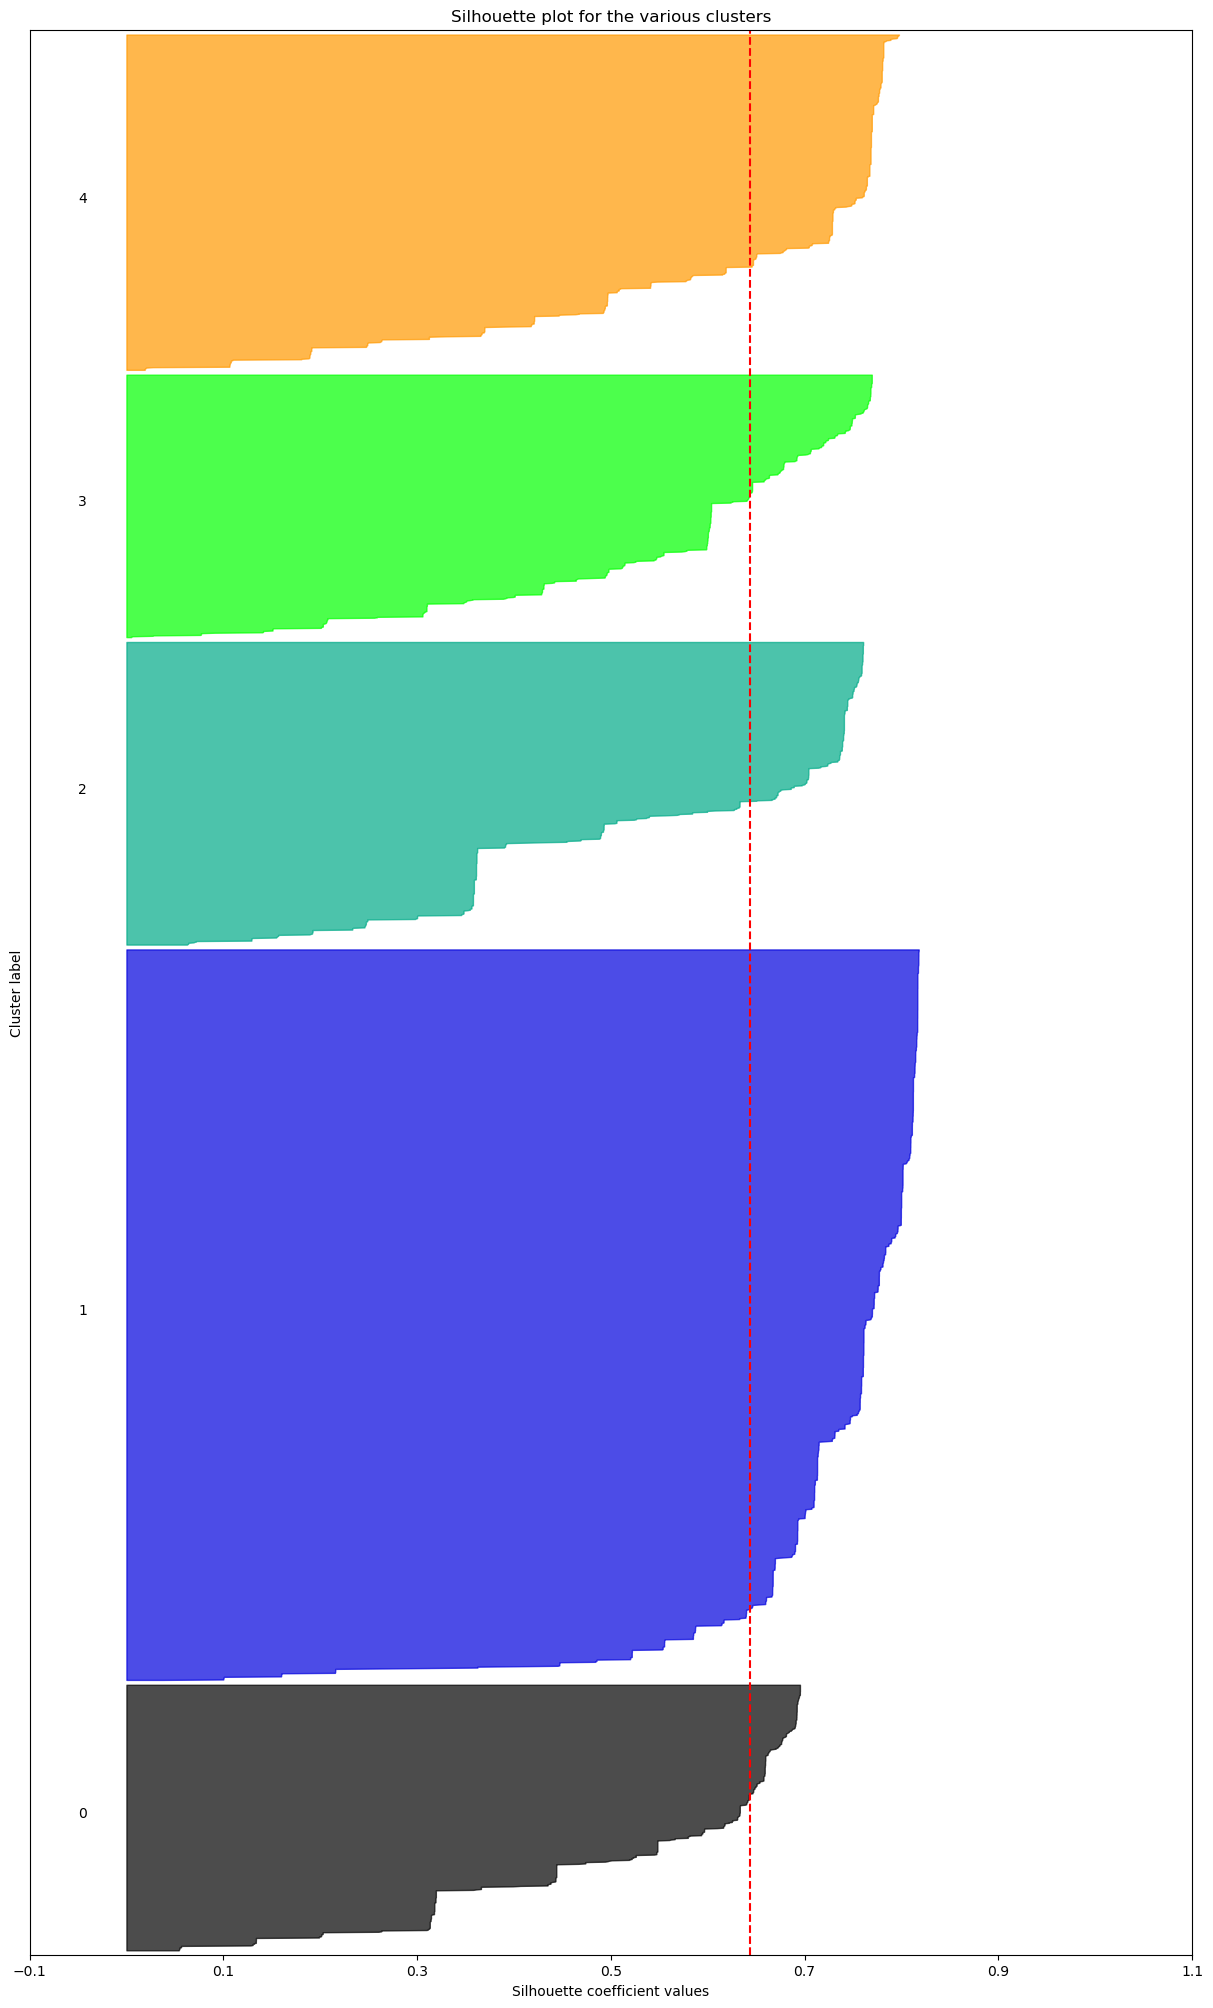

In [458]:

from sklearn.metrics import silhouette_samples, silhouette_score


# حساب Silhouette Scores لكل نقطة
sample_silhouette_values = silhouette_samples(X, labels)

y_lower = 10
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(15, 25)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (optimal_clusters + 1) * 10])

for i in range(optimal_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax1.set_title("Silhouette plot for the various clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()


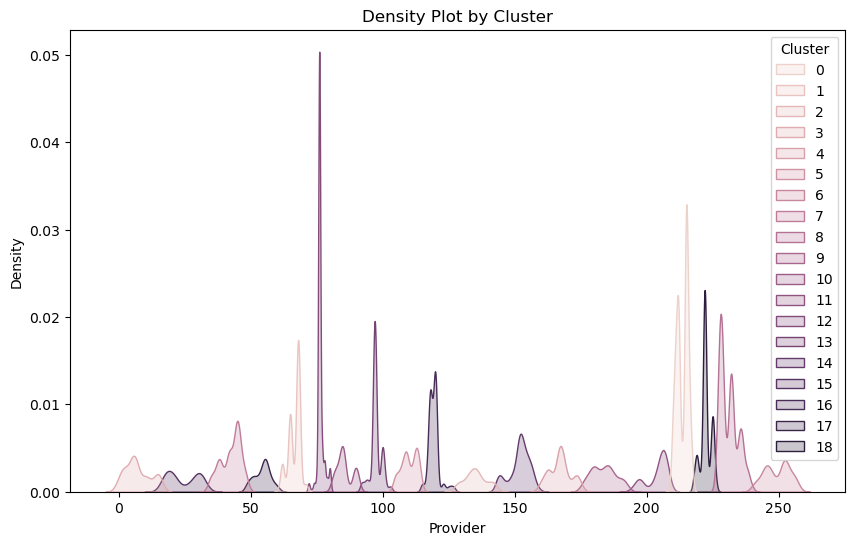

In [459]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_final, x='Provider', hue='Cluster', fill=True)
plt.title('Density Plot by Cluster')
plt.xlabel('Provider')
plt.ylabel('Density')
plt.show()


In [460]:
ff = df_final["Cluster"].unique
print(ff)

<bound method Series.unique of 0        1
1        1
2        1
3        1
4        1
        ..
4299     5
4300     3
4301     7
4302    15
4303    15
Name: Cluster, Length: 4304, dtype: int32>


In [461]:
df

,Rating,Provider,Level,Reviews,Type,Duration / Weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [462]:
df_final_copy = df

In [463]:
df_final_copy

,Rating,Provider,Level,Reviews,Type,Duration / Weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [464]:
df_final_copy['Cluster'] = df_dummies['Cluster']

In [465]:
df_final_copy

,Rating,Provider,Level,Reviews,Type,Duration / Weeks,Cluster
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24,1
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24,1
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24,1
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24,1
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24,1
...,...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4,5
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4,3
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4,7
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4,15


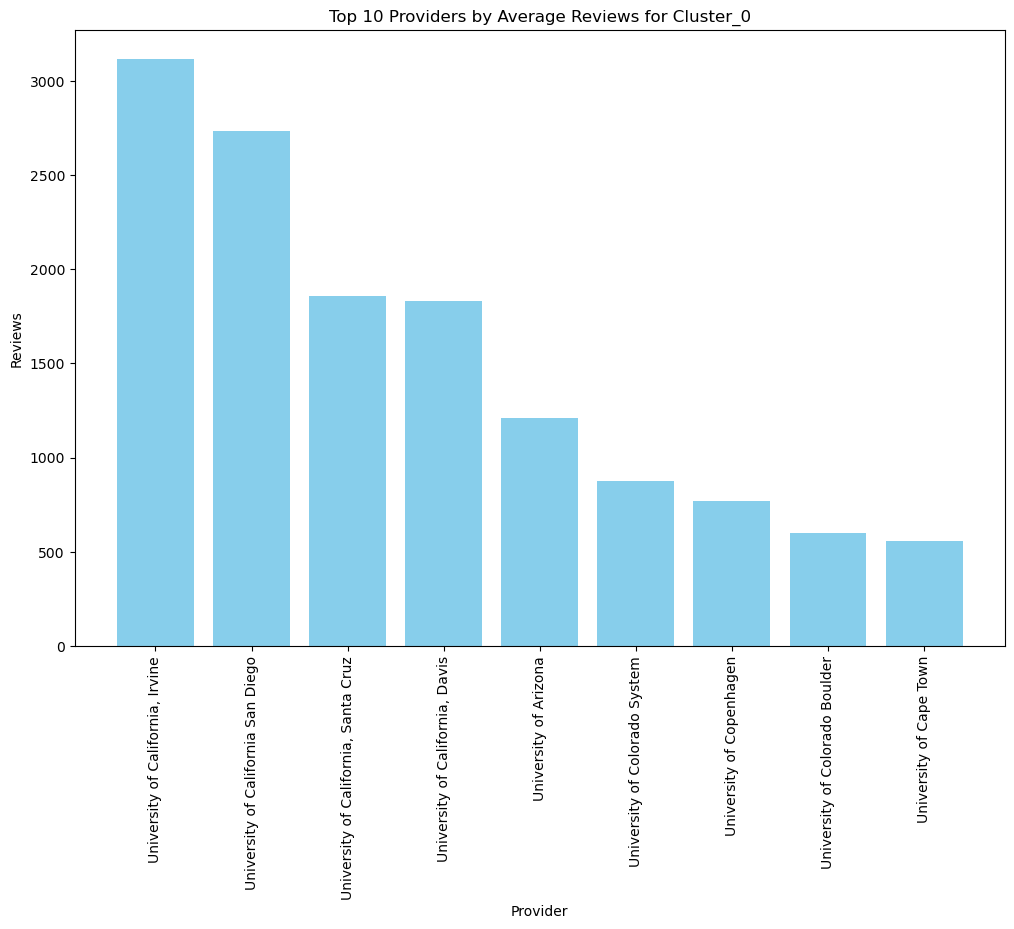

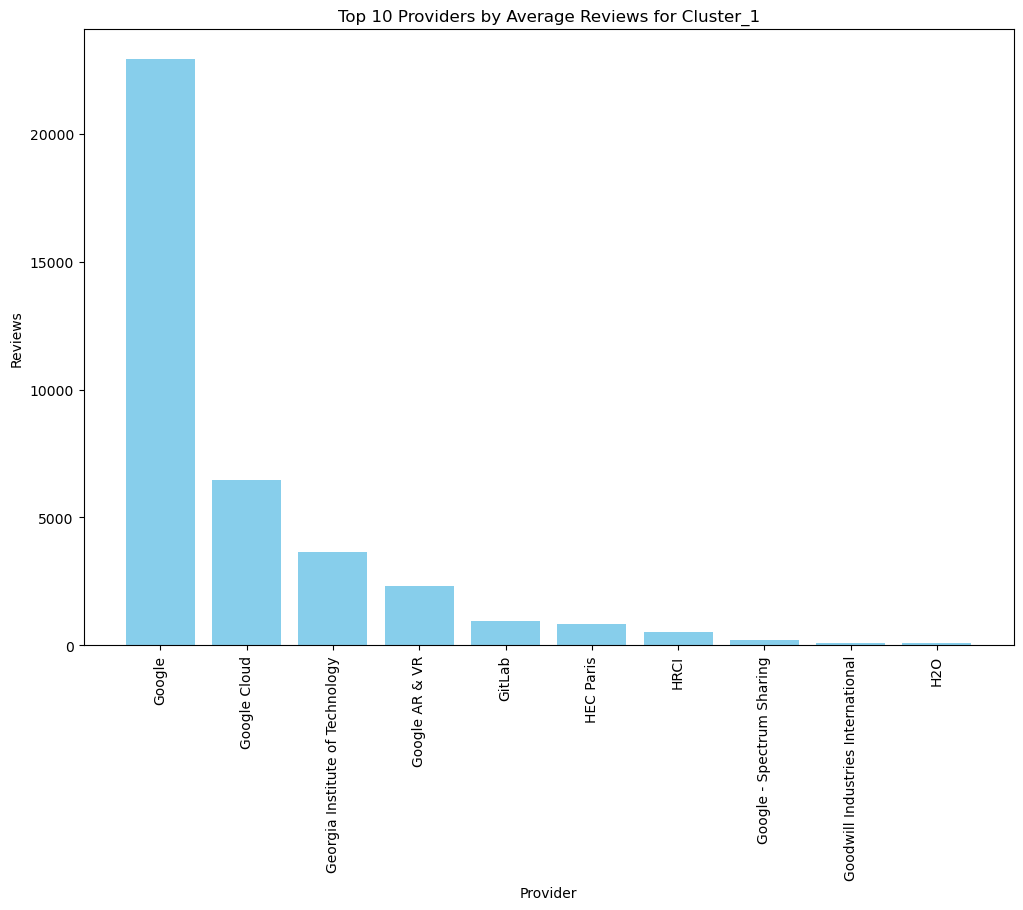

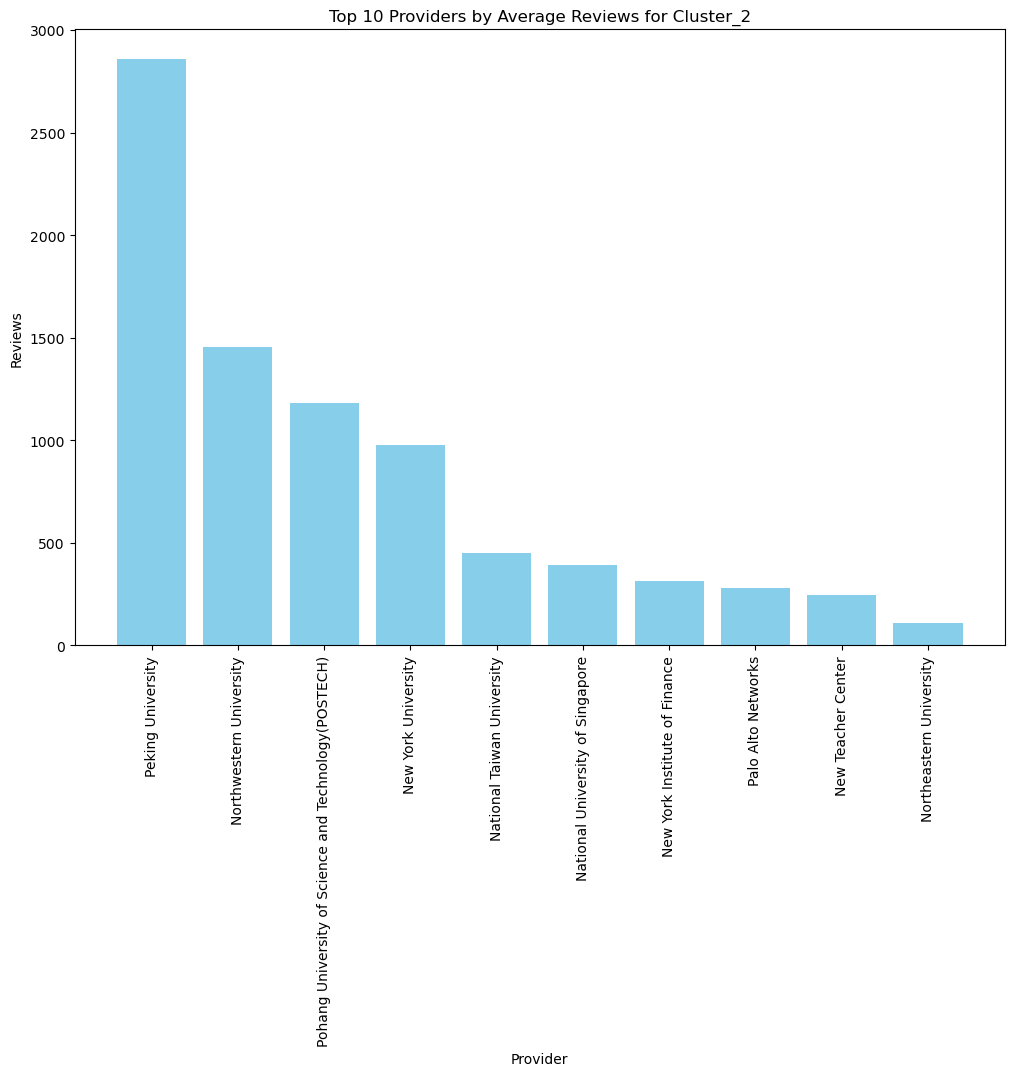

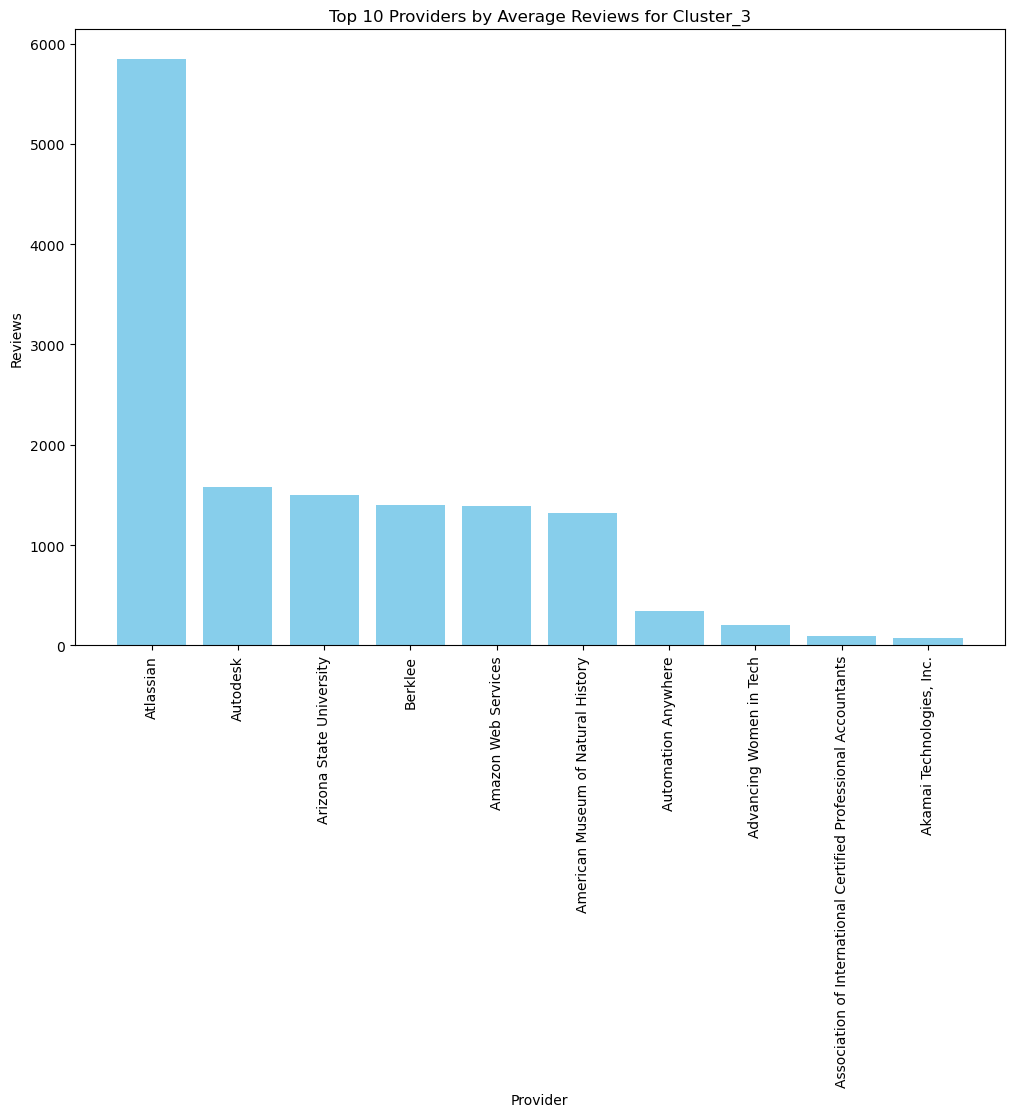

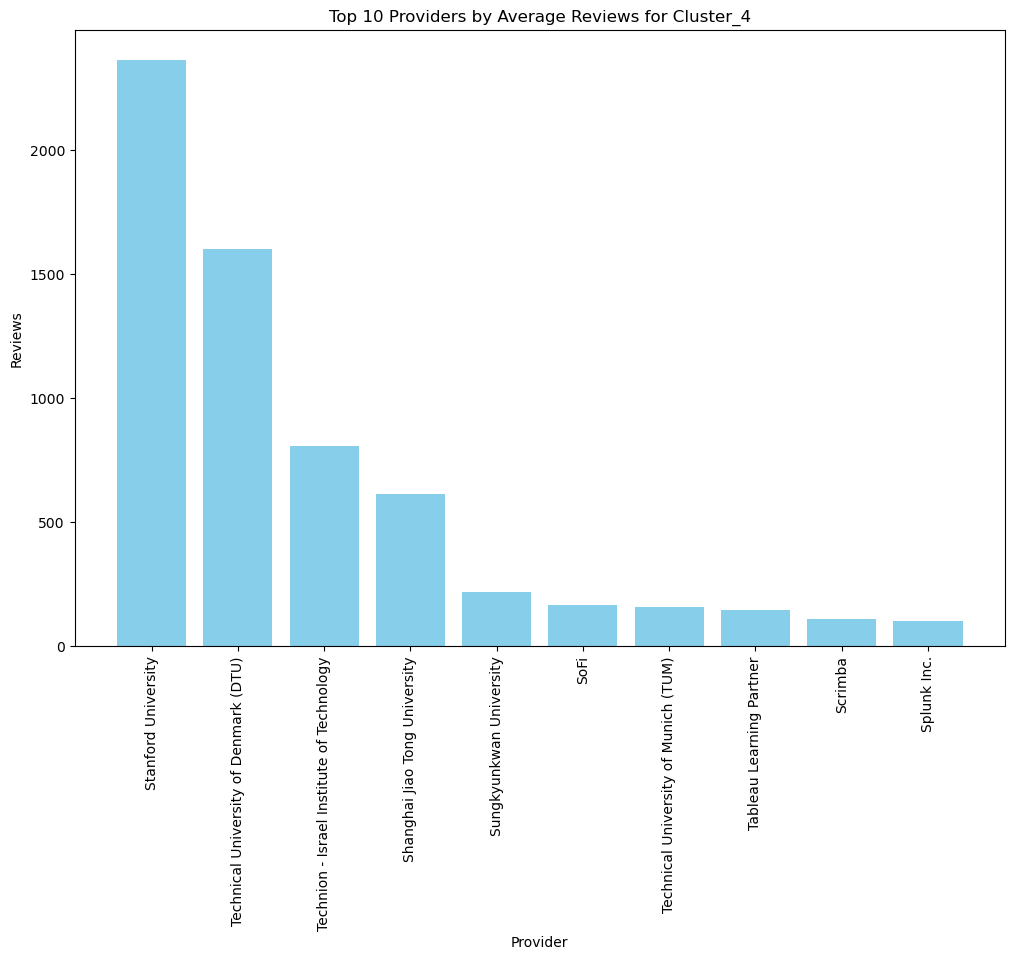

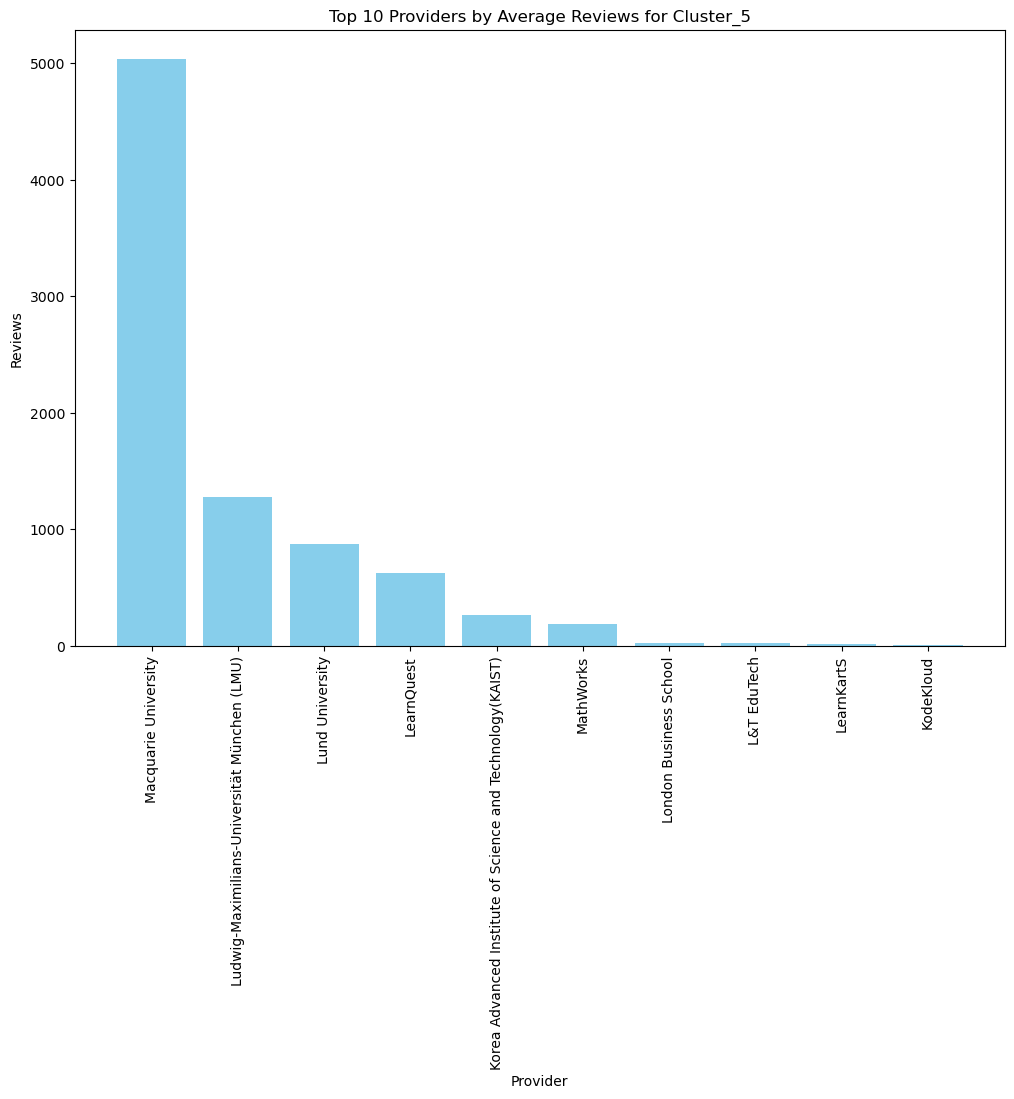

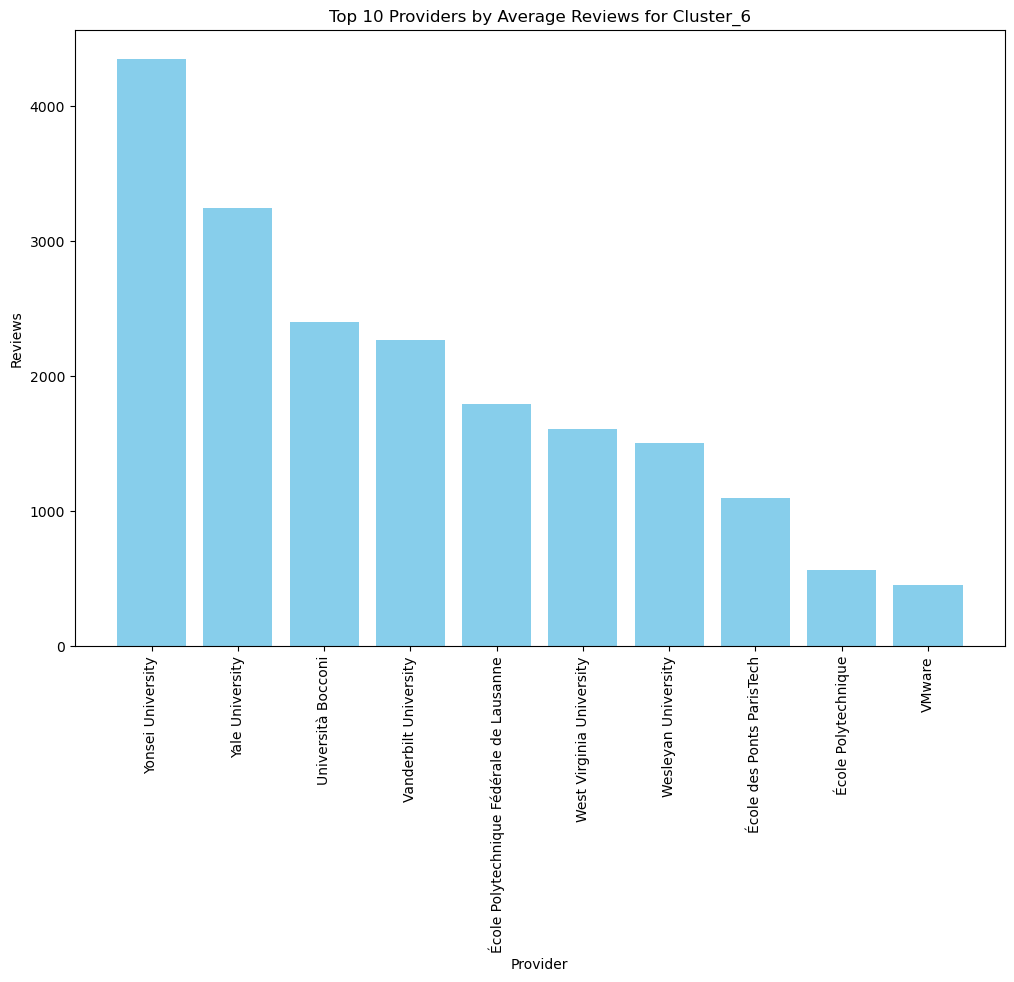

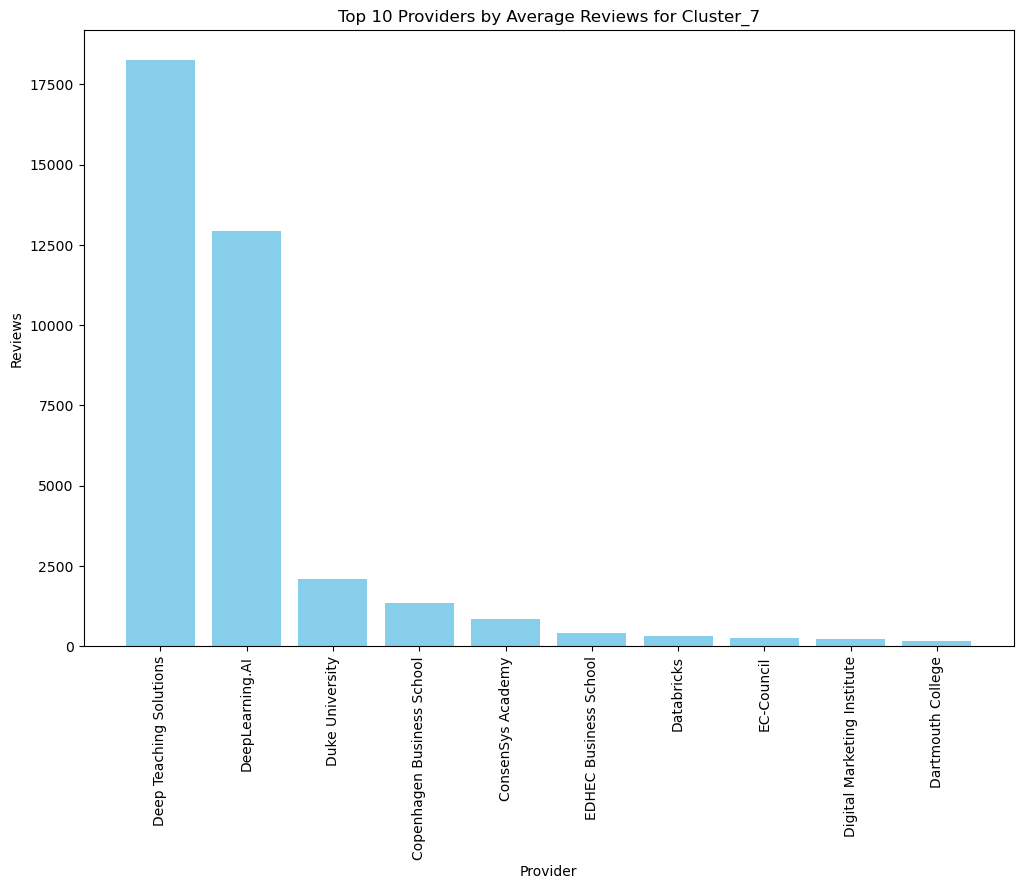

In [466]:


clustered_dfs = {}

for i in range(8):
    clustered_dfs[f'Cluster_{i}'] = df_final_copy[df_final_copy['Cluster'] == i]


for cluster_name, cluster_df in clustered_dfs.items():
    if 'Provider' in cluster_df.columns and 'Reviews' in cluster_df.columns:
        plt.figure(figsize=(12, 8))
        grouped_df = cluster_df.groupby('Provider')['Reviews'].mean().reset_index()
        
        top_10_df = grouped_df.nlargest(10, 'Reviews')
        
        plt.bar(top_10_df['Provider'], top_10_df['Reviews'], color='skyblue')
        plt.title(f'Top 10 Providers by Average Reviews for {cluster_name}')
        plt.xlabel('Provider')
        plt.ylabel('Reviews')
        plt.xticks(rotation=90)  
        plt.show()
    else:
        print(f"Columns 'Provider' or 'Reviews' not found in {cluster_name}.")


In [467]:
for i in range(8):
    clustered_dfs[f'Cluster_{i}'] = df_final_copy[df_final_copy['Cluster'] == i]


df_cluster_0 = clustered_dfs['Cluster_0']
df_cluster_1 = clustered_dfs['Cluster_1']
df_cluster_2 = clustered_dfs['Cluster_2']
df_cluster_3 = clustered_dfs['Cluster_3']
df_cluster_4 = clustered_dfs['Cluster_4']
df_cluster_5 = clustered_dfs['Cluster_5']
df_cluster_6 = clustered_dfs['Cluster_6']
df_cluster_7 = clustered_dfs['Cluster_7']

In [468]:
df_cluster_0['Type'].unique

<bound method Series.unique of 150     Specialization
155     Specialization
162     Specialization
225     Specialization
241     Specialization
             ...      
4269            Course
4270            Course
4275            Course
4279            Course
4296            Course
Name: Type, Length: 555, dtype: object>